# Introduction

### Objective

In this competition, you’re challenged to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue per customer. Hopefully, the outcome will be more actionable operational changes and a better use of marketing budgets for those companies who choose to use data analysis on top of GA data.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from datetime import datetime

import json
import os

import matplotlib.pyplot as plt
import seaborn as sns

from plotly import tools
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.offline as py
import plotly.graph_objs as go

# Read in the data
### Subset

The version 2 of the training data is very large and way more than we need for data visualization and analysis, so we will only take a subset of 700,000 rows

### Timeframe

The subset of training data we are using is from August 2016 to May 2018

### Data Fields

**fullVisitorId** - A unique identifier for each user of the Google Merchandise Store.

**channelGrouping** - The channel via which the user came to the Store.

**date** - The date on which the user visited the Store.

**device** - The specifications for the device used to access the Store.

**geoNetwork** - This section contains information about the geography of the user.

**socialEngagementType** - Engagement type, either "Socially Engaged" or "Not Socially Engaged".

**totals** - This section contains aggregate values across the session.

**trafficSource** - This section contains information about the Traffic Source from which the session originated.

**visitId** - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.

**visitNumber** - The session number for this user. If this is the first session, then this is set to 1.

**visitStartTime** - The timestamp (expressed as POSIX time).

**hits** - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.

**customDimensions** - This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.

**totals** - This set of columns mostly includes high-level aggregate data.

In [2]:
%%time

def load_df(csv_path='../input/train_v2.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'},
                     nrows=nrows)
    
    df = df.drop(['customDimensions','hits'], axis=1)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

train = load_df('../input/train_v2.csv', 700000)
train["totals.transactionRevenue"] = train["totals.transactionRevenue"].astype('float')

CPU times: user 3min 12s, sys: 15.8 s, total: 3min 27s
Wall time: 3min 28s


# First Impressions

In [3]:
print("Colunms: " + str(train.shape[1]))
train[:10]

Colunms: 58


,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,Western Europe,1,1,1,1,1,NaN,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,water bottle,organic,NaN,google
1,Referral,20171016,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,not available in demo dataset,not available in demo dataset,Cupertino,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,(not set),not available in demo dataset,California,Northern America,NaN,2,NaN,2,2,28,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,20171016,7992466427990357681,Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,windjammercable.net,not available in demo dataset,not available in demo dataset,Northern America,NaN,2,1,2,1,38,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,True,NaN,(none),NaN,(direct)
3,Organic Search,20171016,9075655783635761930,Not Socially Engaged,150816

## First Impressions: What We Learned

- Seperating out the JSON colunms baloons the colunms up to 58. A lot of these will be useful, but a lot will not.

- Many colunms seem full of NaN values and many others have almost NaN equivelunt strings like "not available in demo dataset" and "(not set)"

# Looking at NaN Values

In [4]:
train.isnull().sum()

channelGrouping                                           0
date                                                      0
fullVisitorId                                             0
socialEngagementType                                      0
visitId                                                   0
visitNumber                                               0
visitStartTime                                            0
device.browser                                            0
device.browserSize                                        0
device.browserVersion                                     0
device.deviceCategory                                     0
device.flashVersion                                       0
device.isMobile                                           0
device.language                                           0
device.mobileDeviceBranding                               0
device.mobileDeviceInfo                                   0
device.mobileDeviceMarketingName        

## Looking at NaN Values: What We Learned

- <{Write things here}

# Columns with Constant Values

In [5]:
train.nunique(dropna=False)

channelGrouping                                           8
date                                                    258
fullVisitorId                                        585900
socialEngagementType                                      1
visitId                                              680688
visitNumber                                             379
visitStartTime                                       680886
device.browser                                           67
device.browserSize                                        1
device.browserVersion                                     1
device.deviceCategory                                     3
device.flashVersion                                       1
device.isMobile                                           2
device.language                                           1
device.mobileDeviceBranding                               1
device.mobileDeviceInfo                                   1
device.mobileDeviceMarketingName        

In [6]:
const_cols = [c for c in train.columns if train[c].nunique(dropna=False)==1 ]
print("There are "+str(len(const_cols))+" colunms with only one value")
print(const_cols)
train = train.drop(const_cols, axis=1)

['socialEngagementType', 'device.browserSize', 'device.browserVersion', 'device.flashVersion', 'device.language', 'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.operatingSystemVersion', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits', 'trafficSource.adwordsClickInfo.criteriaParameters']


# Transaction Revenue: Exploration

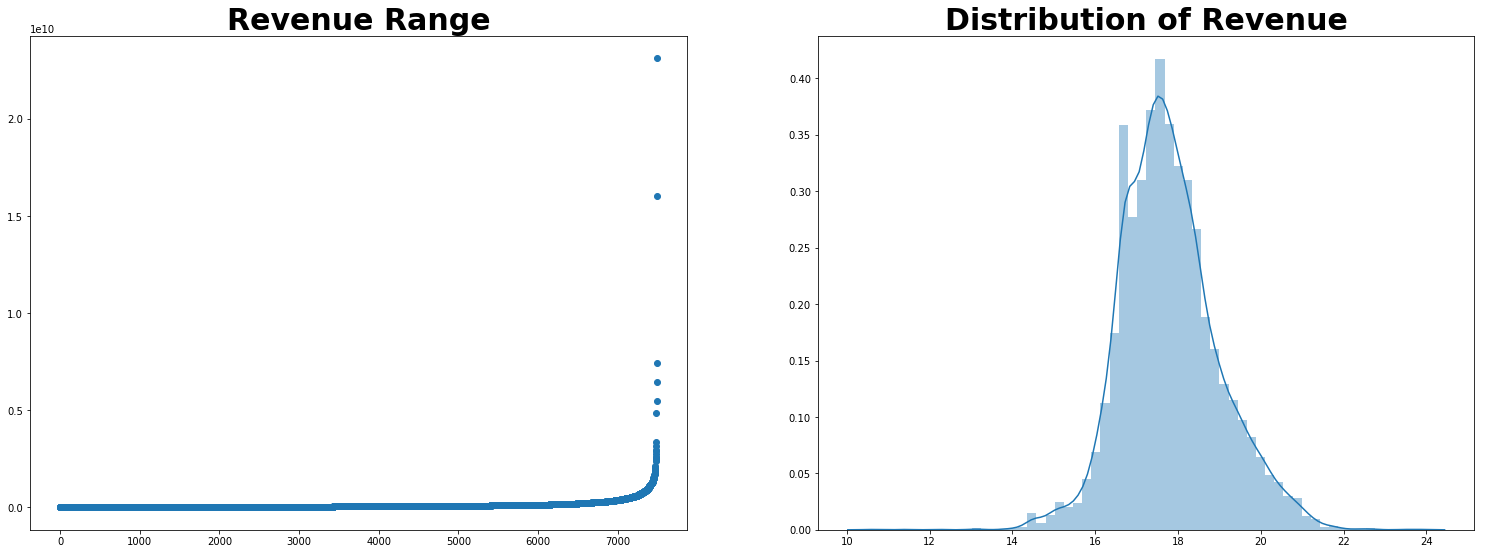

In [7]:
plt.figure(figsize=[40,20])

fontdict = {'fontsize': 30, 'fontweight' : 'bold'}

plt.subplot(231)
plt.scatter(range(train.shape[0]), np.sort(train['totals.transactionRevenue'].values))
plt.title("Revenue Range", fontdict=fontdict)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('')
plt.ylabel('')

plt.subplot(232)
sns.distplot( np.log(train[train['totals.transactionRevenue'] > 0]["totals.transactionRevenue"]), bins=60, kde=True)
plt.title("Distribution of Revenue", fontdict=fontdict)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('')
plt.ylabel('')
plt.show()

## Transaction Revenue: What We Learned

- The vast majorty of visits had no revenue

- The distribution of revenue looks normally distributed

# Visitors: Exploration

In [8]:
print("In the dataset of "+str(train.shape[0])+" visits there are...")
print("Number of unique visitors: "+str(train["fullVisitorId"].nunique()))
print("Presentage of visits that bought something: %"+str(train.loc[train["totals.transactionRevenue"] > 0].shape[0]/train.shape[0]*100))

train_first_visit = train.loc[train["visitNumber"] == 1]
print("Percentage of visits that were for the first time: %"+str(train_first_visit.shape[0]/train.shape[0]*100))
print("Presentage of first time visitors that bought something: %"+str(train_first_visit.loc[train_first_visit["totals.transactionRevenue"] > 0].shape[0]/train.shape[0]*100))

In the dataset of 700000 visits there are...
Number of unique visitors: 585900
Presentage of visits that bought something: %1.0704285714285715
Percentage of visits that were for the first time: %76.94271428571429
Presentage of first time visitors that bought something: %0.432


## Visitors: What We Learned

- Only ~1.1% of visits result in a sale

- Most of the visits are from people visiting for the first time

- First time visitors are much less likely to purchase anything

#  Device Category: Exploration

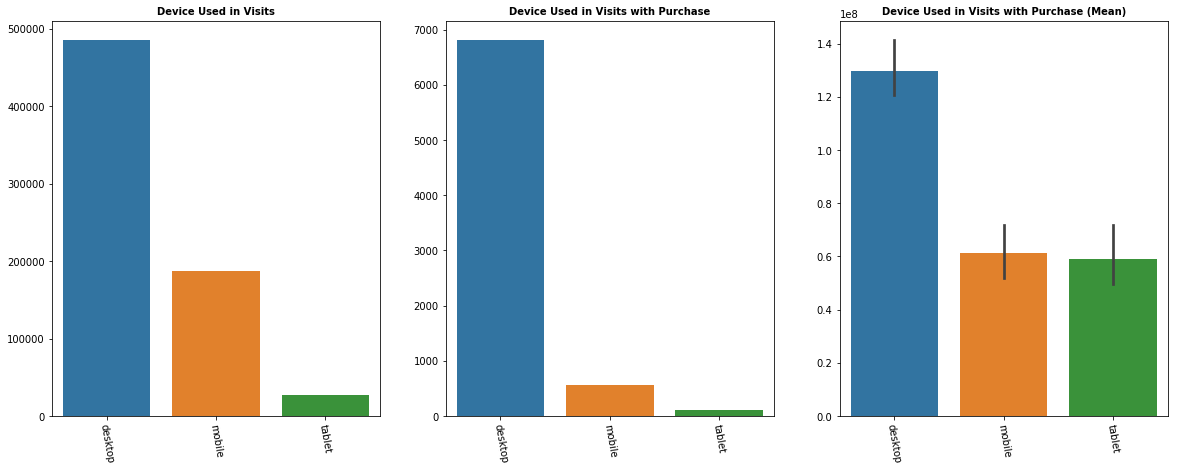

In [9]:
plt.figure(figsize=[20,16])

def create_countplot(column, title, plt_n, df=train, mean_ch = False):
    labels = list(df[column].value_counts().index.unique())

    fontdict = {'fontsize': 10, 'fontweight' : 'bold'}
    plt.subplot(plt_n)
    if mean_ch:
        sns.barplot(x = column, y="totals.transactionRevenue", data=df, order = labels[:10])
    else:
        sns.countplot(x = column, data=df, order = labels[:10])
    plt.xticks(np.arange(0, len(labels[:10]), 1), labels, rotation=-80)
    plt.title(title, fontdict=fontdict)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.xlabel('')
    plt.ylabel('')
    
create_countplot( 'device.deviceCategory', 'Device Used in Visits', 231)
create_countplot( 'device.deviceCategory', 'Device Used in Visits with Purchase', 232, train.loc[train["totals.transactionRevenue"] > 0])
create_countplot( 'device.deviceCategory', 'Device Used in Visits with Purchase (Mean)', 233, train.loc[train["totals.transactionRevenue"] > 0], True)

## Device Category: What We Learned

- Most visits are from a desktop

- Desktop visits are also even more likely to make a purchase and spend more when they do. This intetuitivly makes sense, as most people use their phones on the go and are more likely to be casually browsing prehaps even saving purchases for when they are at a computer.

- While mobile visitor are more common, mobile and tablet visitors seem to have similar behavior. 

# Device Browser: Exploration

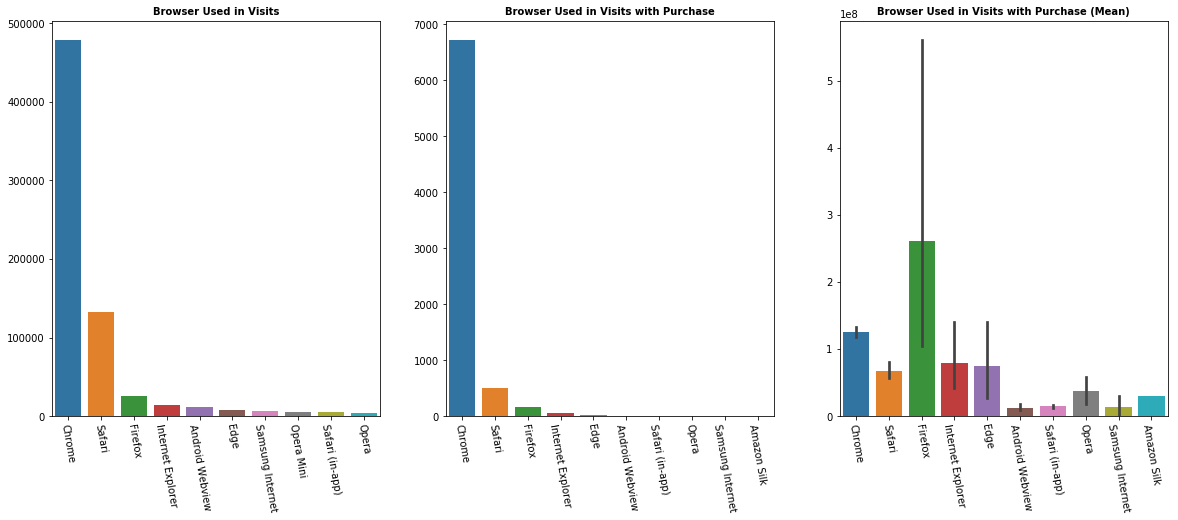

In [10]:
plt.figure(figsize=[20,16])

create_countplot( 'device.browser', 'Browser Used in Visits', 231)
create_countplot( 'device.browser', 'Browser Used in Visits with Purchase', 232, train.loc[train["totals.transactionRevenue"] > 0])
create_countplot( 'device.browser', 'Browser Used in Visits with Purchase (Mean)', 233, train.loc[train["totals.transactionRevenue"] > 0], True)

## Device Browser: What We Learned

- Most visits and visits with purchase are from Chrome browser. Makes sense as Chrome is a Google product and users are probably more likely to be Google fans.

- Firefox seems to have larger purchases. However, the confidence is very low due to the small sample of Firefox purchases so this could very well be a fluke. Other than that, Chrome is confidently higher than the others besides Firefox

# Opperating System: Exploration

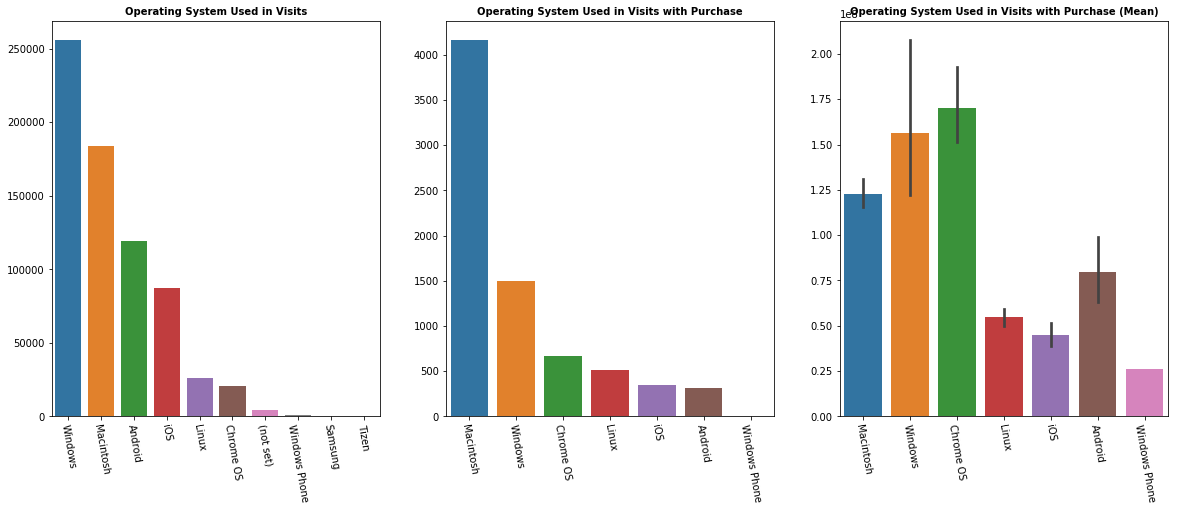

In [11]:
plt.figure(figsize=[20,16])

create_countplot( 'device.operatingSystem', 'Operating System Used in Visits', 231)
create_countplot( 'device.operatingSystem', 'Operating System Used in Visits with Purchase', 232, train.loc[train["totals.transactionRevenue"] > 0])
create_countplot( 'device.operatingSystem', 'Operating System Used in Visits with Purchase (Mean)', 233, train.loc[train["totals.transactionRevenue"] > 0], True)

## Opperating System: What We Learned

- <(write things here)

# Network Domains: Exploration

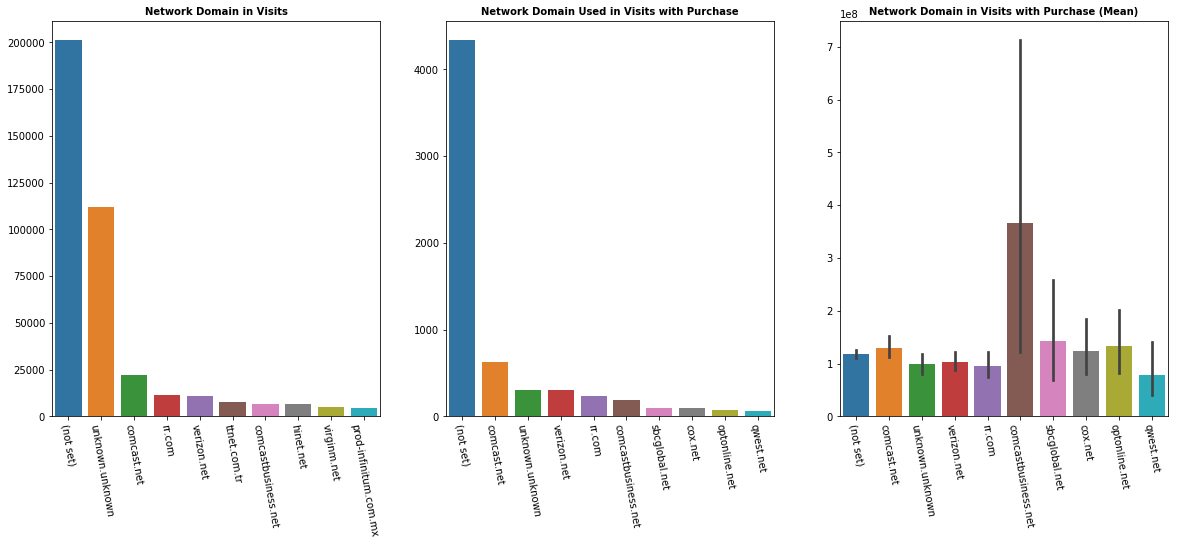

In [12]:
plt.figure(figsize=[20,16])

create_countplot( 'geoNetwork.networkDomain', 'Network Domain in Visits', 231)
create_countplot( 'geoNetwork.networkDomain', 'Network Domain Used in Visits with Purchase', 232, train.loc[train["totals.transactionRevenue"] > 0])
create_countplot( 'geoNetwork.networkDomain', 'Network Domain in Visits with Purchase (Mean)', 233, train.loc[train["totals.transactionRevenue"] > 0], True)

## Network Domains: What We Learned

- <(write things here)

# Continent: Exploration

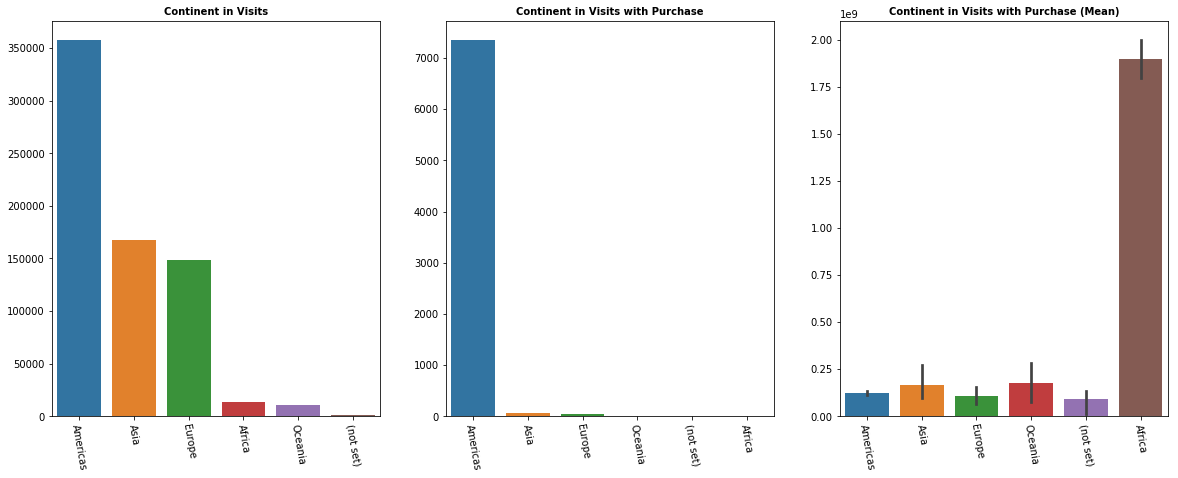

In [13]:
plt.figure(figsize=[20,16])

create_countplot( 'geoNetwork.continent', 'Continent in Visits', 231)
create_countplot( 'geoNetwork.continent', 'Continent in Visits with Purchase', 232, train.loc[train["totals.transactionRevenue"] > 0])
create_countplot( 'geoNetwork.continent', 'Continent in Visits with Purchase (Mean)', 233, train.loc[train["totals.transactionRevenue"] > 0], True)

## Network Domains: What We Learned

- <(write things here)

# Sub Continent: Exploration

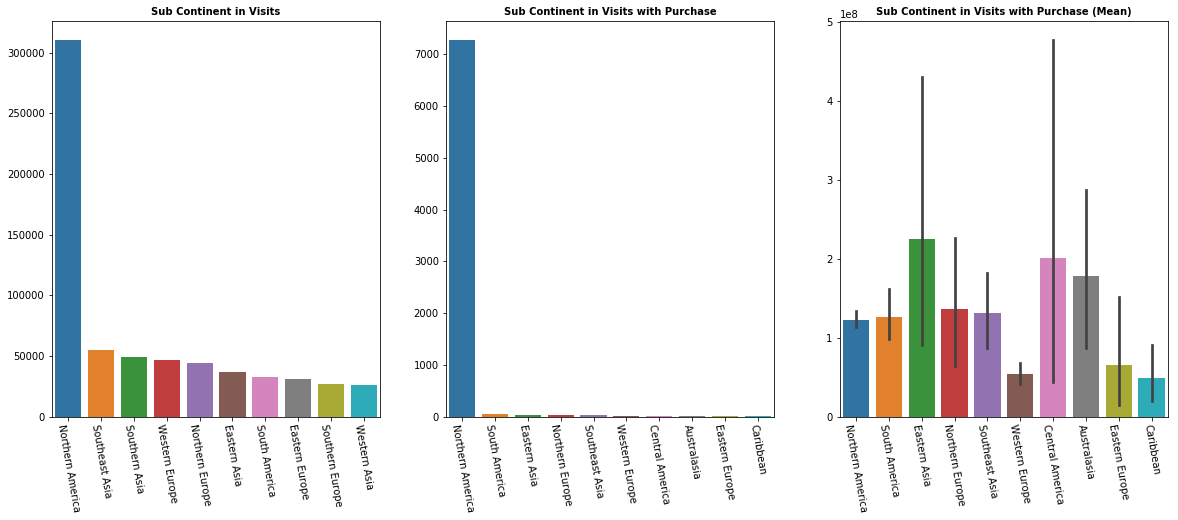

In [14]:
plt.figure(figsize=[20,16])

create_countplot( 'geoNetwork.subContinent', 'Sub Continent in Visits', 231)
create_countplot( 'geoNetwork.subContinent', 'Sub Continent in Visits with Purchase', 232, train.loc[train["totals.transactionRevenue"] > 0])
create_countplot( 'geoNetwork.subContinent', 'Sub Continent in Visits with Purchase (Mean)', 233, train.loc[train["totals.transactionRevenue"] > 0], True)

## Sub Continent: What We Learned

- <(write things here)

# Traffic Source: Exploration

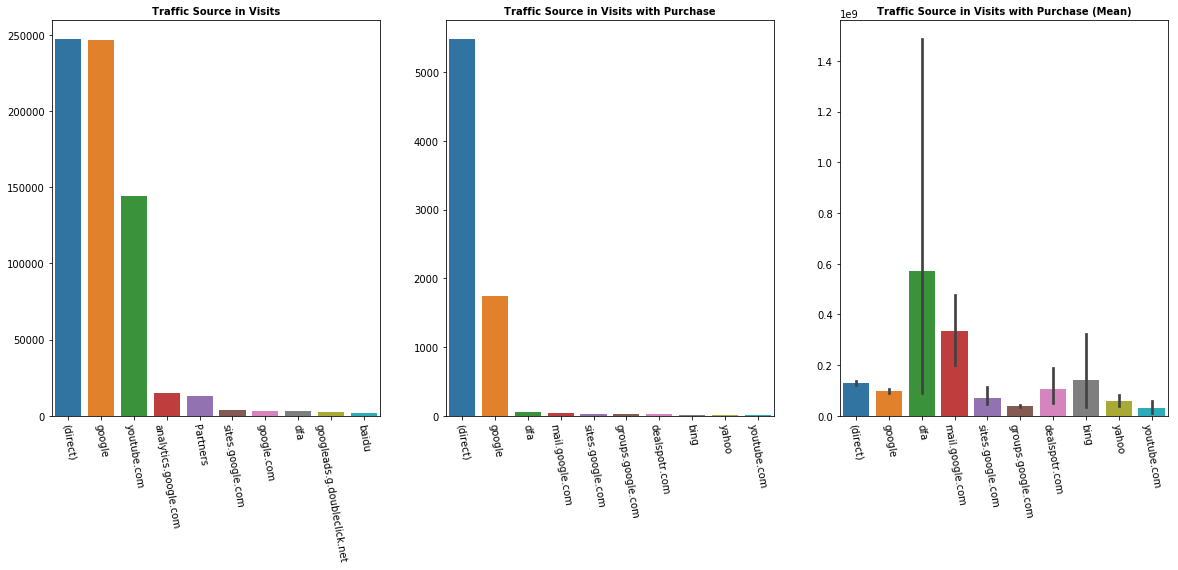

In [15]:
plt.figure(figsize=[20,16])

create_countplot( 'trafficSource.source', 'Traffic Source in Visits', 231)
create_countplot( 'trafficSource.source', 'Traffic Source in Visits with Purchase', 232, train.loc[train["totals.transactionRevenue"] > 0])
create_countplot( 'trafficSource.source', 'Traffic Source in Visits with Purchase (Mean)', 233, train.loc[train["totals.transactionRevenue"] > 0], True)

## Traffic Source: What We Learned

- <(write things here)

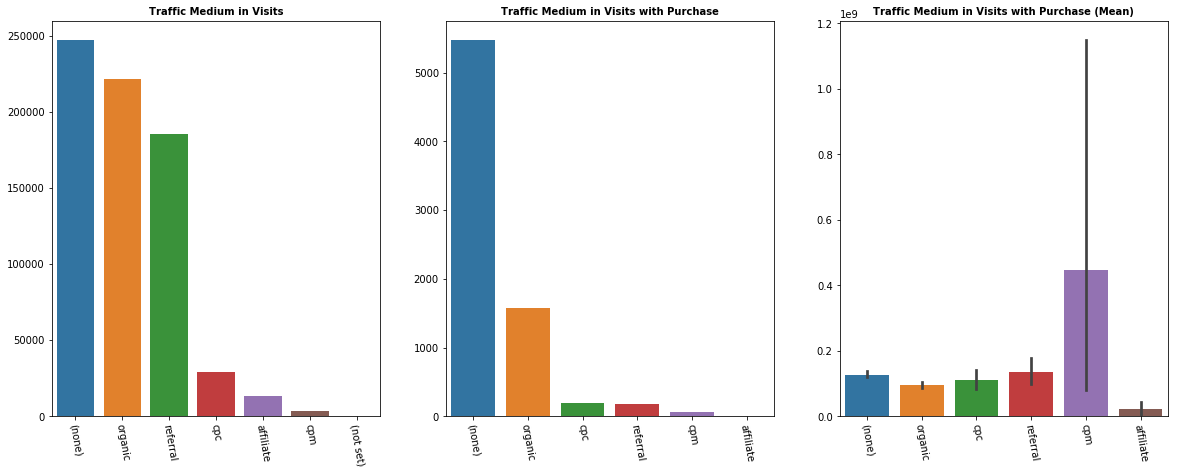

In [16]:
plt.figure(figsize=[20,16])

create_countplot( 'trafficSource.medium', 'Traffic Medium in Visits', 231)
create_countplot( 'trafficSource.medium', 'Traffic Medium in Visits with Purchase', 232, train.loc[train["totals.transactionRevenue"] > 0])
create_countplot( 'trafficSource.medium', 'Traffic Medium in Visits with Purchase (Mean)', 233, train.loc[train["totals.transactionRevenue"] > 0], True)

# Date and Time: Explorations

In [17]:
def time_stamp_features(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df["weekday"] = df['date'].dt.weekday #extracting week day
    df["day"] = df['date'].dt.day # extracting day
    df["month"] = df['date'].dt.month # extracting day
    df["year"] = df['date'].dt.year # extracting day
    df["hour"] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
    return df
time_train = time_stamp_features(train)
p_time_train = time_train.loc[time_train["totals.transactionRevenue"] > 0]

def create_timeplot(var, title, xlabel, ylabel, labels = []):
    plt.figure(figsize=[40,16])
    
    df_count = time_train[var].value_counts().to_frame().reset_index().sort_values('index') 
    df_sum = df_count[var].sum()

    sns.lineplot(x = "index", y = var, data = df_count, estimator=lambda x: x / df_sum * 100, label="%Visits")

    df_count = p_time_train[var].value_counts().to_frame().reset_index().sort_values('index')
    df_sum = df_count[var].sum()

    sns.lineplot(x = "index", y = var, data = df_count, color="Orange", estimator=lambda x: x / df_sum * 100, label="%Visits with Purchase")

    fontdict = {'fontsize': 40, 'fontweight' : 'bold'}

    plt.title(title, fontdict=fontdict)
    plt.tick_params(axis='both', which='major', labelsize=30)
    if labels != []:
        plt.xticks(np.arange(0, len(labels), 1), labels)
    plt.xlabel(xlabel, fontdict=fontdict)
    plt.ylabel(ylabel, fontdict=fontdict)
    plt.legend(fontsize=30)
    plt.show()

# Hour of the Day: Exploration

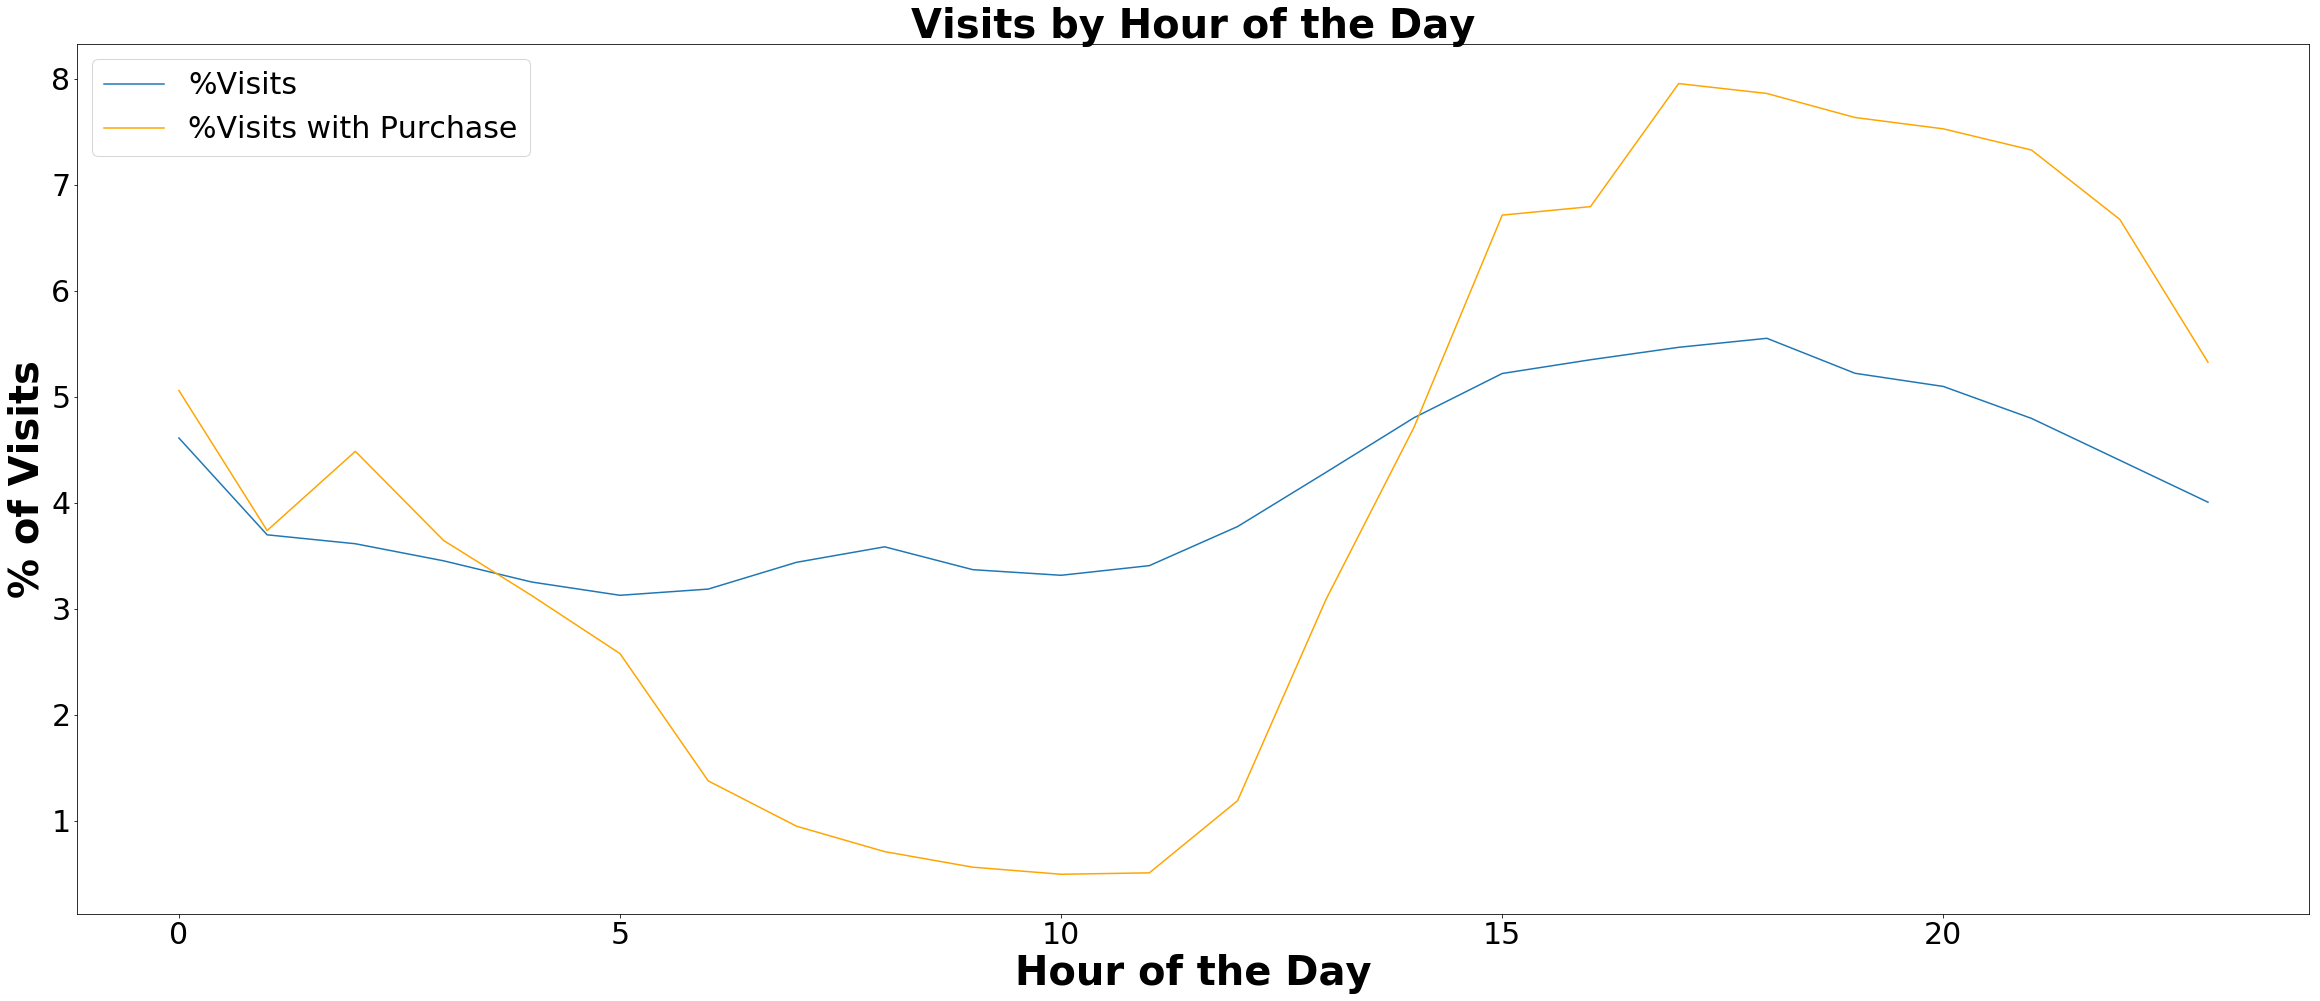

In [18]:
create_timeplot("hour","Visits by Hour of the Day","Hour of the Day", "% of Visits")

## Hour of the Day: What We Learned

- Even though people visit the site from all over the world, there is a clear difference in visit at different times during the day. This is likely because the vast majority of visits and purchases are from america and the more active hours for the site are during the afternoon-night in america.

- While both lines follow the same trend, the visits with purchase line is much more pronounced. Noting again that these lines follow american timezones, we can also infer that while people might still visit the site different hours of the day, few people seem less inclinded to make purchases durring late night/early morning hours and are more likely to actually pull out their credit cards and make a purchase in the evening.

# Date: Exploration

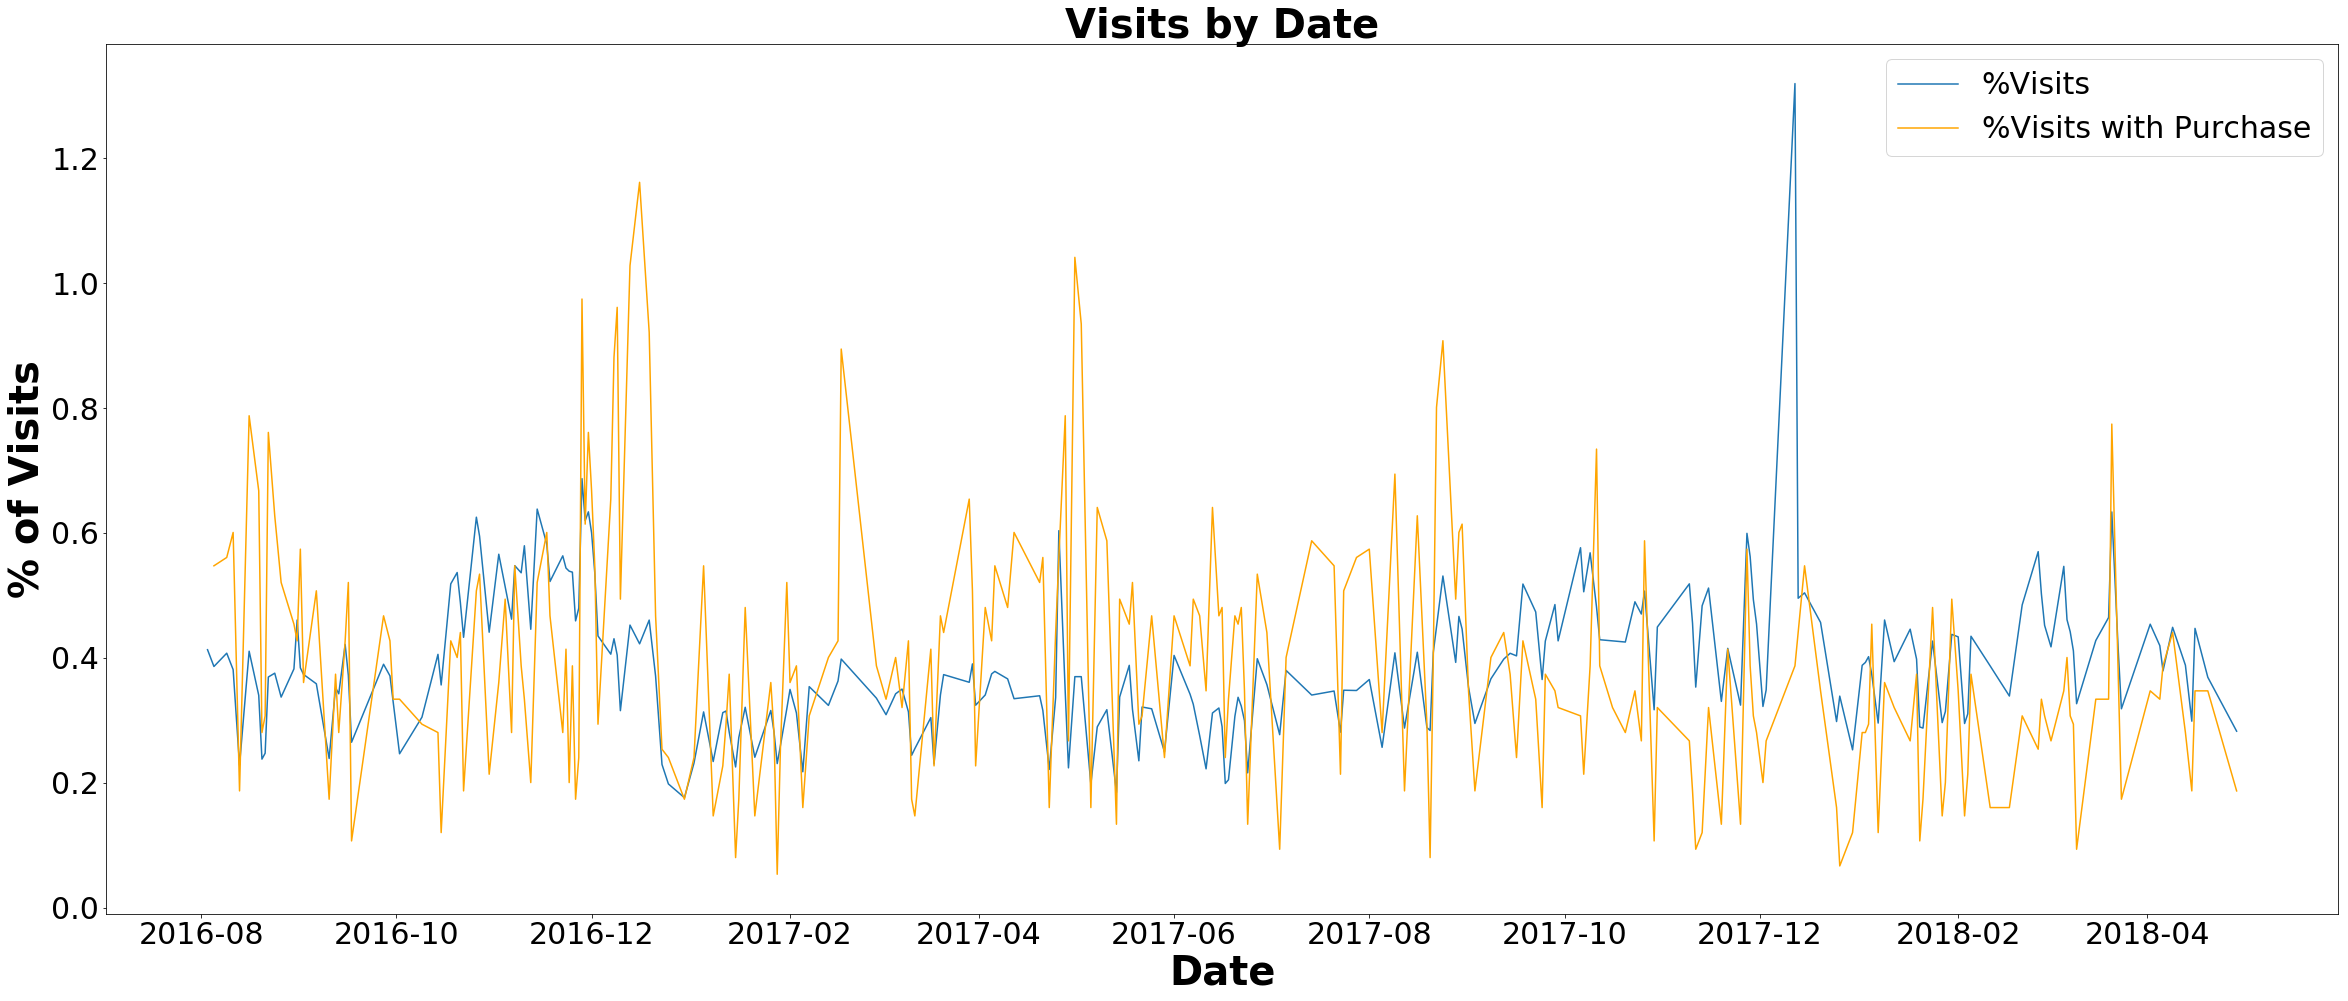

In [19]:
create_timeplot("date","Visits by Date","Date", "% of Visits")

# Date: What We Learned

- <(write things here)

# Weekday: Exploration

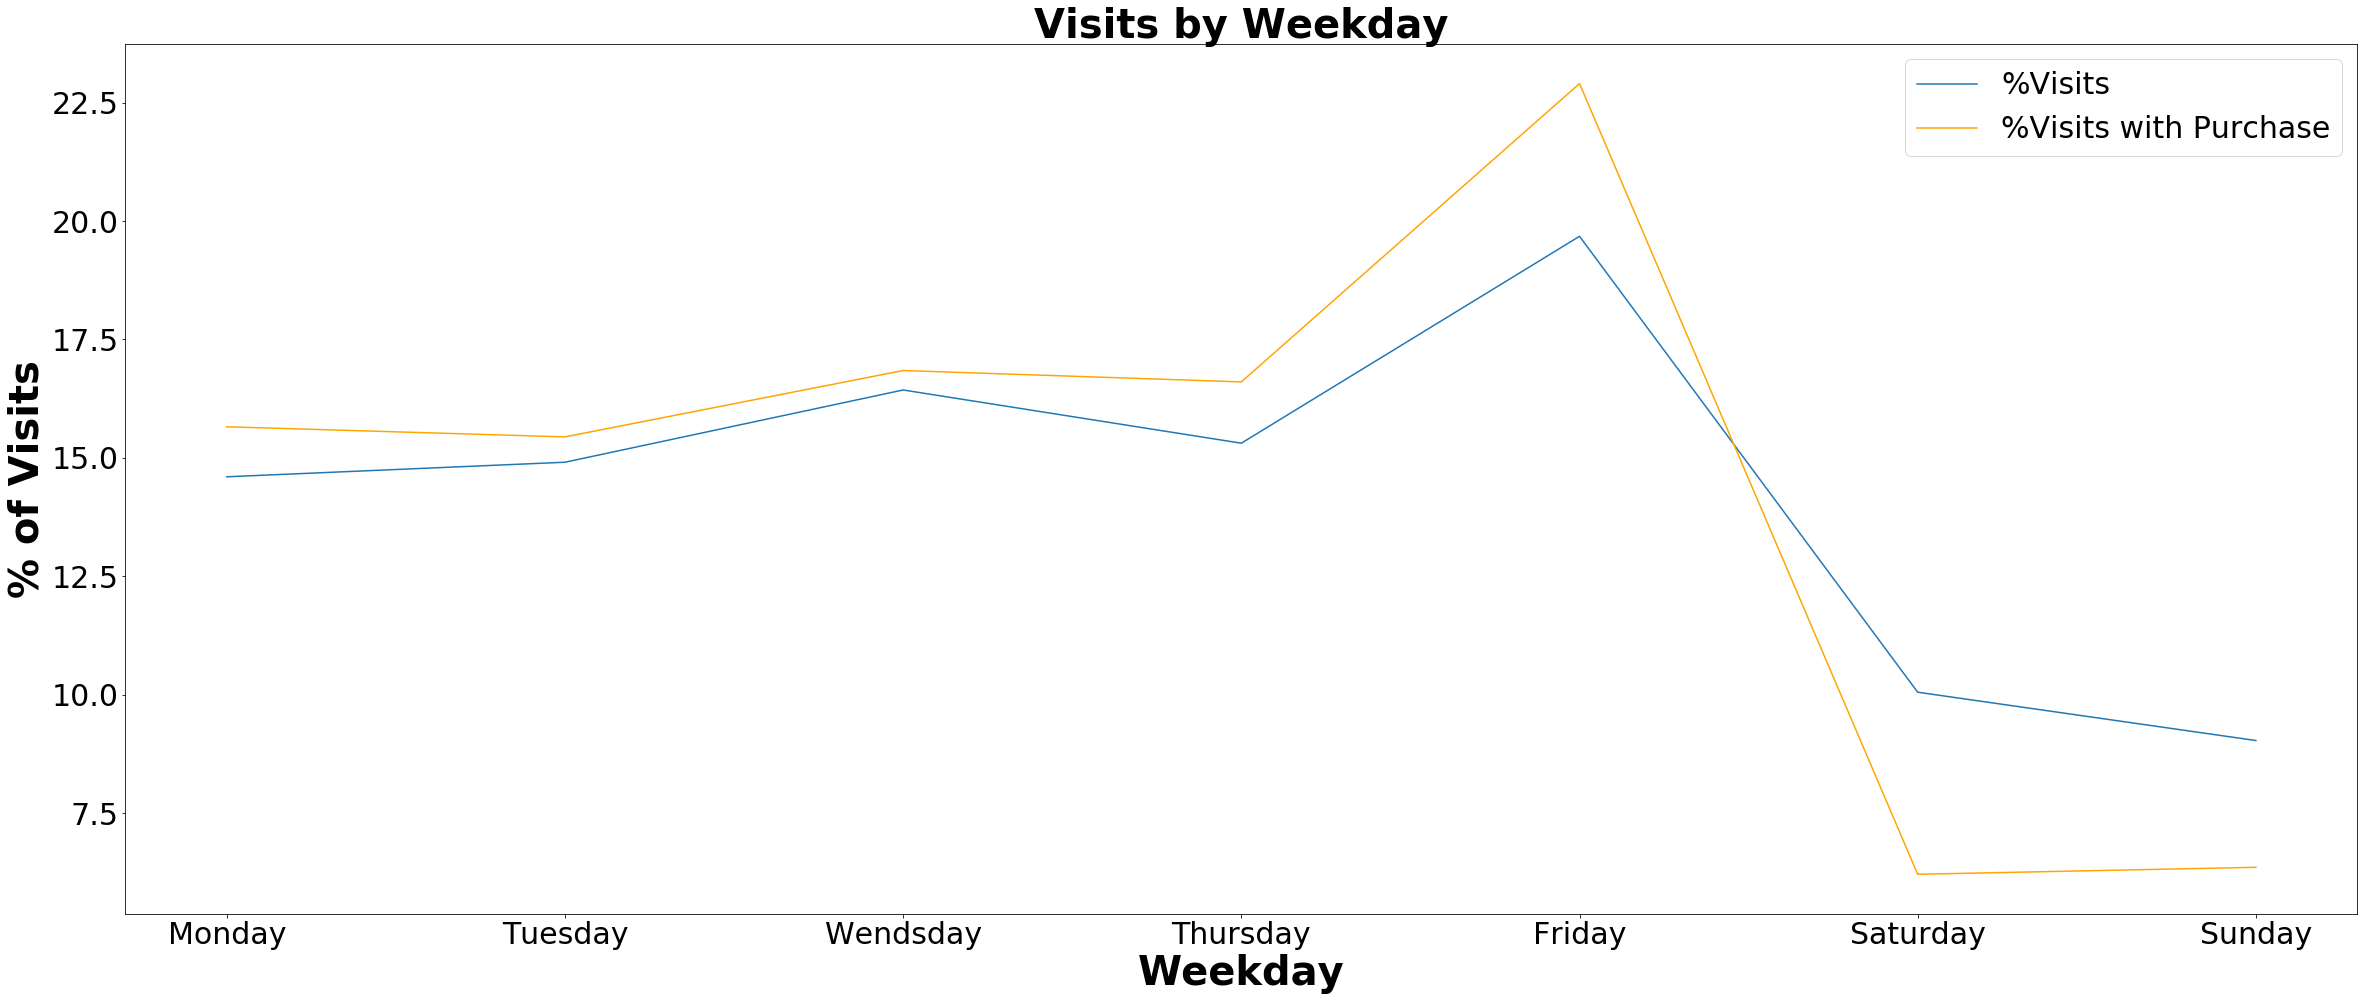

In [20]:
create_timeplot("weekday","Visits by Weekday","Weekday", "% of Visits", ["Monday","Tuesday","Wendsday", "Thursday", "Friday", "Saturday", "Sunday"])

## Weekday: What We Learned

- <(write things here)

# Page Views and Hits: Exploration

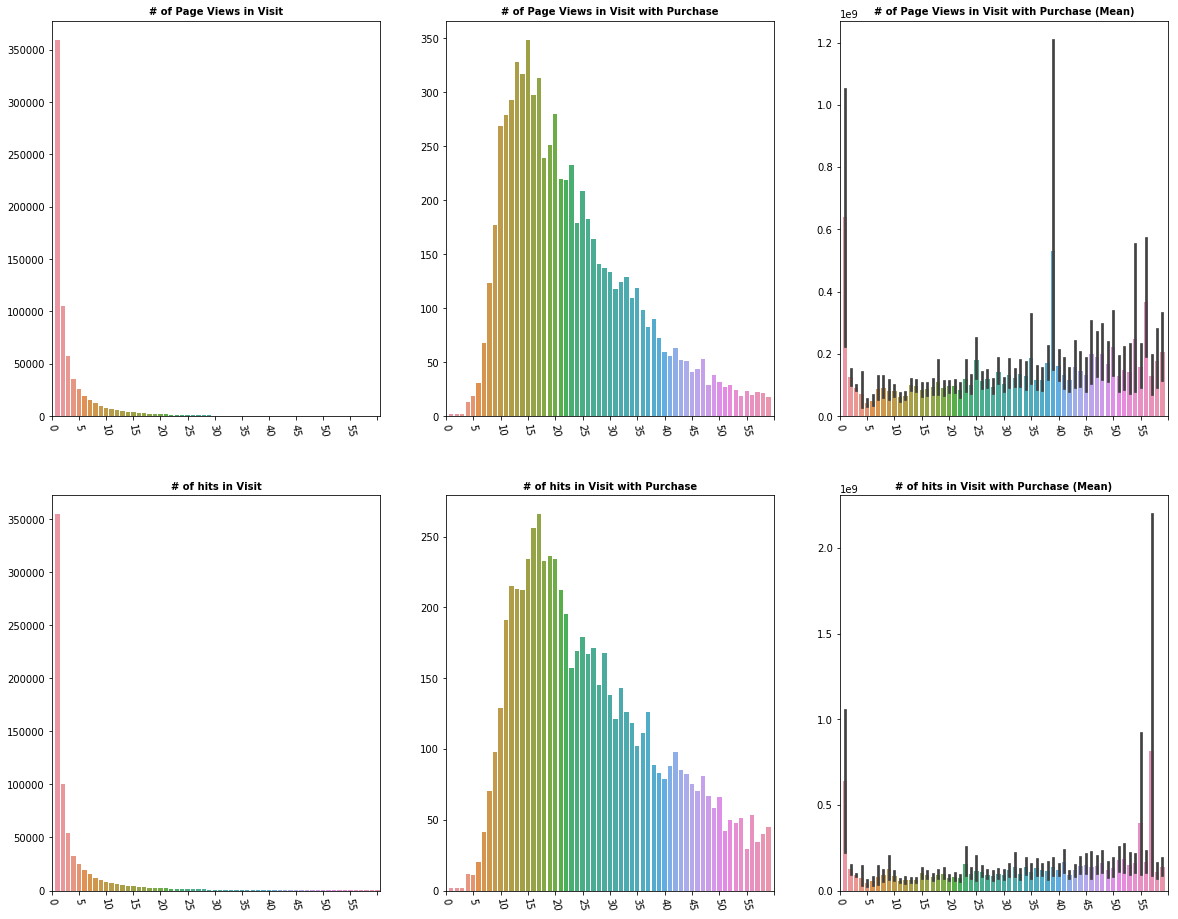

In [21]:
train['totals.pageviews'] = train['totals.pageviews'].astype("float")
train['totals.hits'] = train['totals.hits'].astype("float")

plt.figure(figsize=[20,16])
def create_viewplot(column, title, plt_n, df=train, mean_ch = False):
    df = df.loc[df[column] <= 60].sort_values(column) 
    labels = np.arange(0, 60, step=5)
    fontdict = {'fontsize': 10, 'fontweight' : 'bold'}
    plt.subplot(plt_n)
    if mean_ch:
        sns.barplot(x = column, y="totals.transactionRevenue", data=df)
    else:
        sns.countplot(x = column, data=df)
    plt.xticks(np.arange(-1, 60, step=5),labels, rotation=-80)
    plt.title(title, fontdict=fontdict)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.xlabel('')
    plt.ylabel('')

create_viewplot( 'totals.pageviews', '# of Page Views in Visit', 231)
create_viewplot( 'totals.pageviews', '# of Page Views in Visit with Purchase', 232, train.loc[train["totals.transactionRevenue"] > 0])
create_viewplot( 'totals.pageviews', '# of Page Views in Visit with Purchase (Mean)', 233, train.loc[train["totals.transactionRevenue"] > 0], True)

create_viewplot( 'totals.hits', '# of hits in Visit', 234)
create_viewplot( 'totals.hits', '# of hits in Visit with Purchase', 235, train.loc[train["totals.transactionRevenue"] > 0])
create_viewplot( 'totals.hits', '# of hits in Visit with Purchase (Mean)', 236, train.loc[train["totals.transactionRevenue"] > 0], True)

plt.show()

## Weekday: What We Learned

- The Page Views and Hits charts are all very similar and there are no real notable differences. This is likely because they are so strongly correnlated with each other and only have slightly different meanings.

- Purchase visits max around 15-20 page view/hits and follow a right-skewed distribution.

- While the means revenue graphs have some spikes throughout the charts, the low confidence rates and scattered occorances suggest that this is likely just from small subsample sizes. 

- That being said, there might still be some eveidce that single page/hit visitors make larger purchases, on the rare chance that they do, since both means graphs show rather large spikes at 1 visit hits. This *might* be true because they might have been following direct links to the site and already had their purchase in mind with no interest in browsing.

# "Conculsion"

(Data visialzations and analysis notebooks often don't have or need an overall conculsion, but maybe we could add one anyways if we want to)